<a href="https://colab.research.google.com/github/AstroNoodles/Mini-Projects/blob/master/DiabetesRegression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Diabetes Linear Regression

This Jupyter notebook will be used to test my skills on linear regression based on the [diabetes dataset](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html), readily available in the Sci-kit Learn Python library.

To first bring some context to the data, it was collected by Bradley Efron, Trevor Hastie, Iain Johnston and Robert Tishiranie in 2004 as an analysis of their new 'Least Angle Regression' (LARS) algorithm designed to outcompete previous linear regression methods (such as Lasso regression). 

The outline of this notebook will be as follows"
* Receiving the data from Scikit-Learn
* Doing introductory preprocessing and visualization
* Testing out various regression methods (LARS, Lasso, Linear, Polynomial, SVR)
* Finding their accuracy using RMSE [Root Mean Squared Error] 
* Use of grid search to increase accuracy and deep learning (Tensorflow) to decrease the loss over time...



In [0]:
import numpy as np
import matplotlib.pyplot as plt
from math import ceil
import seaborn as sns
from sklearn.datasets import load_diabetes
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoCV, LassoLarsCV, Ridge
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression


%matplotlib inline

# Preprocessing

According to the source page, there is a sample size of 442 individuals in the data with 10 features and 1 target value. In the numpy array that will be downloaded, these features are 
* Age
* Sex
* BMI
* Average Blood Pressure
* Six Blood Serum measurements
* A quantitative measure of disease progression after the baseline

According to [Scikit-learn](https://scikit-learn.org/stable/datasets/index.html#diabetes-dataset), the downloaded data has already been scaled for us with a centered mean and with the standard deviation * 442. Therefore, we don't have to scale the data and can proceed to explore it and use it for modelling!

In [20]:
db_data = load_diabetes()
print(f"Diabetes Features: {db_data.feature_names} \n")
print(f"Diabetes Data: \n {db_data.data[:5]} \n")
print(f"Diabetes Target: \n {db_data.target[:5]} \n")

Diabetes Features: ['age', 'sex', 'bmi', 'bp', 's1', 's2', 's3', 's4', 's5', 's6'] 

Diabetes Data: 
 [[ 0.03807591  0.05068012  0.06169621  0.02187235 -0.0442235  -0.03482076
  -0.04340085 -0.00259226  0.01990842 -0.01764613]
 [-0.00188202 -0.04464164 -0.05147406 -0.02632783 -0.00844872 -0.01916334
   0.07441156 -0.03949338 -0.06832974 -0.09220405]
 [ 0.08529891  0.05068012  0.04445121 -0.00567061 -0.04559945 -0.03419447
  -0.03235593 -0.00259226  0.00286377 -0.02593034]
 [-0.08906294 -0.04464164 -0.01159501 -0.03665645  0.01219057  0.02499059
  -0.03603757  0.03430886  0.02269202 -0.00936191]
 [ 0.00538306 -0.04464164 -0.03638469  0.02187235  0.00393485  0.01559614
   0.00814208 -0.00259226 -0.03199144 -0.04664087]] 

Diabetes Target: 
 [151.  75. 141. 206. 135.] 



In [21]:
# Let's get a sample of the data (80%) so we can visualize it and do some preprocessing on it
# I will be using cross-validation so I won't have access to a proper training set
diabetes_len = len(db_data.data)
X = db_data.data[:int(ceil(diabetes_len*.8))]
y = db_data.target[:int(ceil(diabetes_len*.8))]
np.random.seed(42)
np.random.shuffle(X)
np.random.shuffle(y)

print("Training Data Sample: ")
print(X[:5])
print()


print("Correlation Matrix: ")
corr = np.corrcoef(X, rowvar=False)
print(corr)

Training Data Sample: 
[[ 0.02354575  0.05068012 -0.03961813 -0.00567061 -0.04835136 -0.03325502
   0.01182372 -0.03949338 -0.10164355 -0.06735141]
 [-0.06000263  0.05068012 -0.0105172  -0.0148516  -0.04972731 -0.02354742
  -0.0581274   0.0158583  -0.00991896 -0.03421455]
 [-0.0382074  -0.04464164 -0.0547075  -0.0779709  -0.03321588 -0.08649026
   0.14068104 -0.0763945  -0.01919705 -0.0052198 ]
 [ 0.04897352 -0.04464164 -0.04285156 -0.0538708   0.04521344  0.05004247
   0.03391355 -0.00259226 -0.02595242 -0.0632093 ]
 [-0.04183994 -0.04464164  0.04121778 -0.02632783 -0.03183992 -0.03043668
  -0.03603757  0.00294291  0.03365681 -0.01764613]]

Correlation Matrix: 
[[ 1.          0.17455991  0.20179956  0.31649285  0.27685043  0.23276066
  -0.04131083  0.18811178  0.2578946   0.28764571]
 [ 0.17455991  1.          0.07951261  0.21744559 -0.00105342  0.12150539
  -0.37846636  0.31450944  0.10028456  0.23149279]
 [ 0.20179956  0.07951261  1.          0.39568054  0.28726412  0.30720414
  -0.

Text(0.5, 1.0, 'Correlation Matrix on Diabetes Dataset')

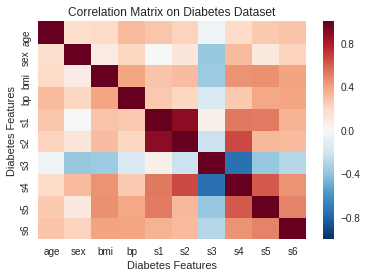

In [22]:
sns.heatmap(corr, xticklabels=db_data.feature_names, yticklabels=db_data.feature_names)
plt.xlabel("Diabetes Features")
plt.ylabel("Diabetes Features")
plt.title("Correlation Matrix on Diabetes Dataset")

According to the heat map above, none of the variabes seem directly correlated together except for the first and second serum measurements. Therefore, it is hard to combine them manually.

In an attempt to visualize this data for multivariate linear regression, we need to combine the most correlated parameters via a different means, this will be done via SelectKBest and the linear regression scoring method (1). From this, we can create a regression plot.



(354, 10) (354,)
(354, 1) (354,)


Text(0.5, 1.0, 'Serum measurement on the prediction of diabetes')

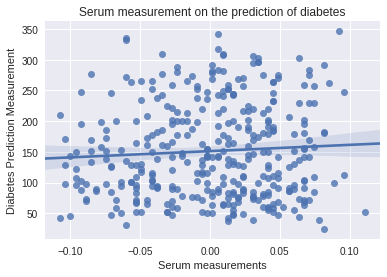

In [28]:
# Original Shapes of the Data
print(X.shape, y.shape)

# With the most correlated item of the dataset, match the shapes of the samples
X_st = SelectKBest(f_regression, k=1).fit_transform(X, y)
print(X_st.shape, y.shape)

sns.regplot(X_st, y)
plt.xlabel("Serum measurements")
plt.ylabel("Diabetes Prediction Measurement")
plt.title("Serum measurement on the prediction of diabetes")

With this regression plot as a starting point, we can try to improve upon this score using linear regression algorithms and check whether the slope of the line matches the slope found by the algorithms in the noisy data or too much data was lost (1) in the data visualization and a better slope can be found

# Model Development

Let's gather some models to predict the likelihood of diabetes given the serum measurements and most important features.

In [0]:
models = [LinearRegression(n_jobs=-1)]

for model in models:
  cross_val_scores = cross_val_score(model, db_data.data, db_data.target, cv=5)
  
  model_name = type(model).__name__
  print(f"Accuracy of {model_name}: {cross_val_scores.mean():.2f} +/- {[cross_val_scores.std()*2]:.2f}")

# Notes and References:



1.   There are errors that can made through attempting to reduce the dimensionality for visualization (Kaski and Peltonen, 2011), which is measured by calculating the precision and recall for the parameters left out of the visualization, so tests may have to be performed multiple times.
2.   List item



1.   Kaski S and Peltonen J (2011). Dimensionality Reduction for Data Visualization. IEEE Signal Processing Magazine 28(2):101-104. doi: https://doi.org/10.1109/MSP.2010.940003
2.   List item



ValueError: ignored

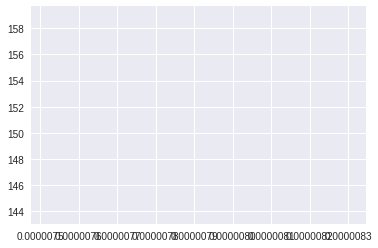

In [16]:
# The original shapes
print(X.shape, y.shape)



Differences between the Different Regression algorithms: [see here](https://www.analyticsvidhya.com/blog/2017/06/a-comprehensive-guide-for-linear-ridge-and-lasso-regression/). Also, can use the SelectBest scikit learn algorithm to get rid of some of the dimensions of the data. LASSO gets rid of the coefficients that don't matter to 0. Ridge is faster and easier to compute.
